## Import relevant libraries

In [1]:
import re
import io
import time

#General libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for data pre-processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score,recall_score,f1_score
from sklearn import preprocessing

#For Decision Tree implementation
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier

# For Random Forest implementation
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# For KNN
from sklearn.neighbors import KNeighborsClassifier

# For Naive Bayes implementation
from sklearn.naive_bayes import GaussianNB

#For Logisitic Regression implmentation
from sklearn.linear_model import LogisticRegression

# For SVM
from sklearn.svm import LinearSVC
# For K-Means
from sklearn.cluster import KMeans

# For Ensembling 
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import StackingClassifier

# for xgboost
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from datetime import datetime
begin = datetime.now()
start=datetime.now()

import warnings
warnings.filterwarnings('ignore')

import random

# Set random seed for the Python environment
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
!pip install --upgrade scikit-learn

## Import CSV

In [3]:
df = pd.read_csv('./Datasets/googleplaystore_cleaned.csv')

In [4]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Genre 1,Genre 2
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,0.0,Everyone,Art & Design,201801,1.00,4.03,Art & Design,-
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,201801,2.00,4.03,Art & Design,Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,0.0,Everyone,Art & Design,201808,1.24,4.03,Art & Design,-
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,Free,0.0,Teen,Art & Design,201806,0.00,4.20,Art & Design,-
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,0.0,Everyone,Art & Design;Creativity,201806,1.10,4.40,Art & Design,Creativity


## Drop unwanted columns

In [5]:
df.drop(['Genres', 'Android Ver', 'Current Ver', 'Type', 'Price'], axis = 1, inplace=True)

In [6]:
df.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs',
       'Content Rating', 'Last Updated', 'Genre 1', 'Genre 2'],
      dtype='object')

## Define Success Metrics for Classification

In [7]:
# classify ratings into {0, 1} based on our success metrics
df['Success'] = np.where((df['Rating'] > 4.05) & (df['Installs'] > 1000) & (df['Reviews'] > 2585), 1, 0)
df['Success'].value_counts()

0    4918
1    3960
Name: Success, dtype: int64

## Relations

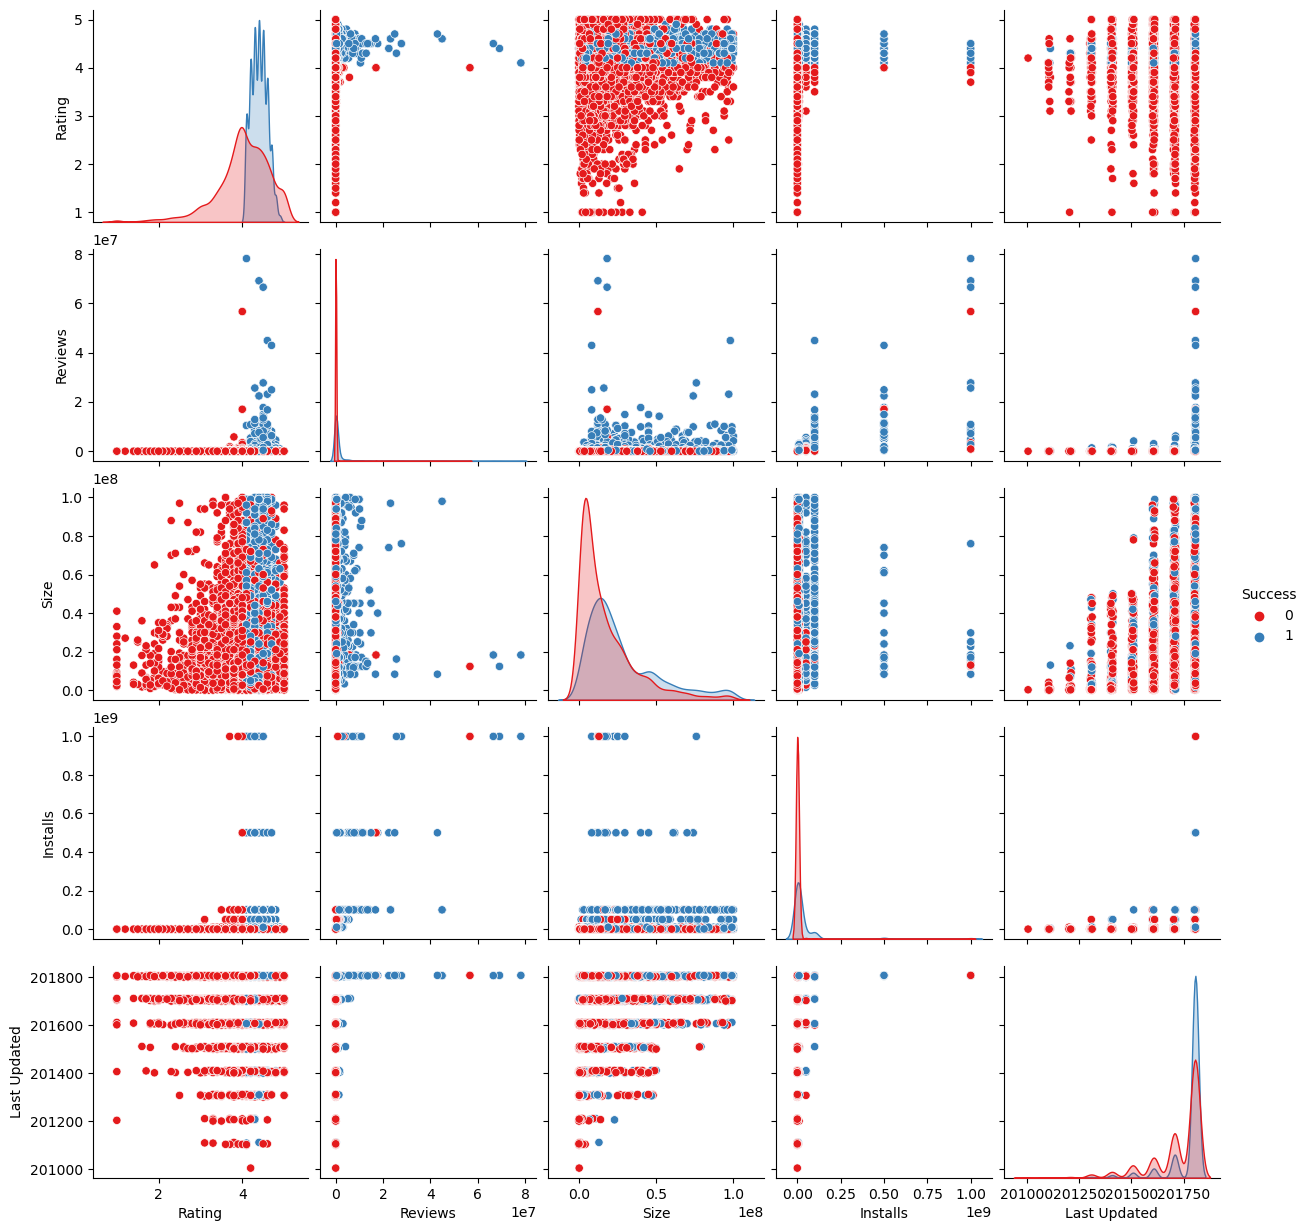

In [8]:
# observe where apps of good rating lies on the distribution of variables 
sns.pairplot(df, hue='Success',palette='Set1')

## Encode

In [9]:
df_original = df.copy() # holds original values (non-encoded ver)

In [10]:
# Encode all features in df into numeric values
for column in df.columns:
    if df[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        df[column] = le.fit_transform(df[column])

## PCA 

Eigenvalues:
[1.95559188 1.73024874 1.22999456 1.0748817  0.97410542 0.94081982
 0.84284489 0.67618396 0.36243469 0.21402086]

Explained variances (percentage):
[19.55371602 17.30053847 12.29856016 10.74760624  9.73995694  9.40713843
  8.42749952  6.761078    3.62393864  2.13996756]



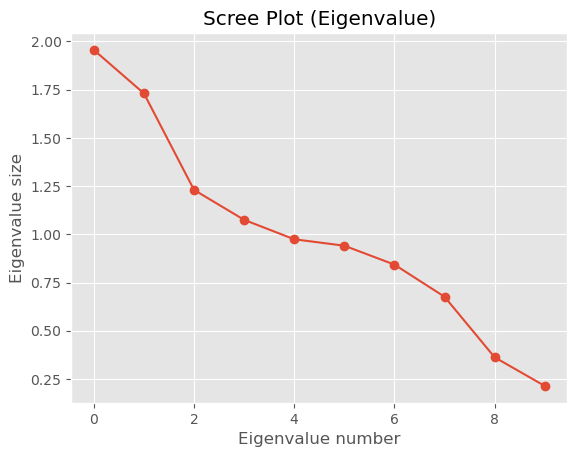

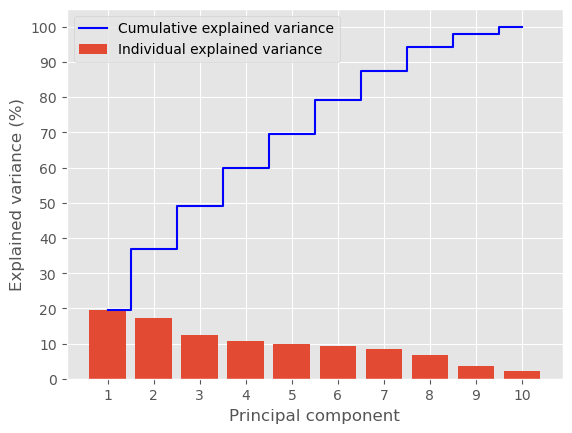

Number of principal components to retain based on 85% cumulative explained variance: 7


In [11]:
X = df.drop(['Success'], axis=1)
y = df['Success']

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=None))
])

# Fit the pipeline to the data
pipe.fit(X)

# Print the eigenvalues
print("Eigenvalues:")
print(pipe.named_steps['pca'].explained_variance_)
print()

# Print the eplained variance %
exp_var = pipe.named_steps['pca'].explained_variance_ratio_ * 100
print("Explained variances (percentage):")
print(exp_var)
print()

# Calculate cumulative explained variance
cumulative_var = np.cumsum(pipe.named_steps['pca'].explained_variance_ratio_) * 100

# Create scree plot
plt.style.use('ggplot')
plt.plot(pipe.named_steps['pca'].explained_variance_, 'o-')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot (Eigenvalue)")
plt.show()

# Plot individual & cumulative explained variance %
plt.bar(range(1, 11), exp_var, align='center',
        label='Individual explained variance')
plt.step(range(1, 11), cumulative_var, where='mid',
         label='Cumulative explained variance', color='blue')
plt.ylabel('Explained variance (%)')
plt.xlabel('Principal component')
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.yticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.legend(loc='best')
plt.show()

# Determine number of principal components to retain
num_components = np.sum(cumulative_var < 85) + 1
print("Number of principal components to retain based on 85% cumulative explained variance:", num_components)

# Fit the pipeline with the chosen number of components
pipe.named_steps['pca'].n_components = num_components
X_pca = pipe.transform(X)

## Train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

## Supervised Learning

### Logistic Regression

In [13]:
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)

predictions = log_model.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
6390,0,0
229,0,0
8101,1,0
1680,1,1
7323,0,0
7794,0,0
6630,0,0
7564,0,1
7632,0,0
4861,1,0


Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       995
           1       0.70      0.68      0.69       781

    accuracy                           0.73      1776
   macro avg       0.73      0.73      0.73      1776
weighted avg       0.73      0.73      0.73      1776

Confusion Matrix: 
[[772 223]
 [253 528]]
Accuracy:  0.7319819819819819
Precision:  0.7030625832223701
Recall:  0.676056338028169
F1:  0.6892950391644909
Time taken:  0:01:24.749637


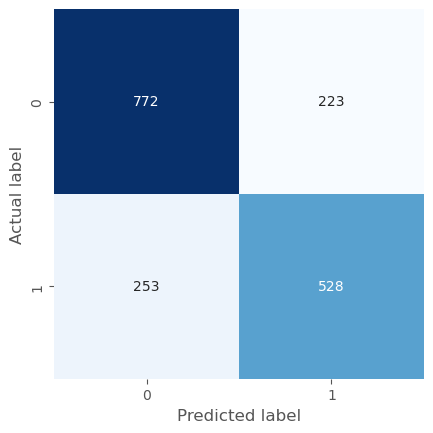

In [14]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


In [15]:
# Evaluate performance on the training set
y_train_pred = log_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Evaluate performance on the test set
y_test_pred = log_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the performance metrics
print("Training accuracy: {:.2f}".format(train_acc))
print("Training precision: {:.2f}".format(train_prec))
print("Training recall: {:.2f}".format(train_rec))
print("Training recall: {:.2f}".format(train_f1))
print("Test accuracy: {:.2f}".format(test_acc))
print("Test precision: {:.2f}".format(test_prec))
print("Test recall: {:.2f}".format(test_rec))
print("Test recall: {:.2f}".format(test_f1))

Training accuracy: 0.72
Training precision: 0.70
Training recall: 0.67
Training recall: 0.68
Test accuracy: 0.73
Test precision: 0.70
Test recall: 0.68
Test recall: 0.69


### Decision Tree

In [16]:
model = DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df.sample(10)


,Actual,Predicted
6592,0,0
7296,0,1
7291,1,1
4851,1,0
1981,0,0
2960,1,1
2215,1,1
5336,0,0
5241,0,0
5521,0,0


Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       995
           1       0.73      0.75      0.74       781

    accuracy                           0.77      1776
   macro avg       0.76      0.77      0.77      1776
weighted avg       0.77      0.77      0.77      1776

Confusion Matrix: 
[[775 220]
 [192 589]]
Accuracy:  0.7680180180180181
Precision:  0.7280593325092707
Recall:  0.7541613316261203
F1:  0.740880503144654
Time taken:  0:01:25.656352


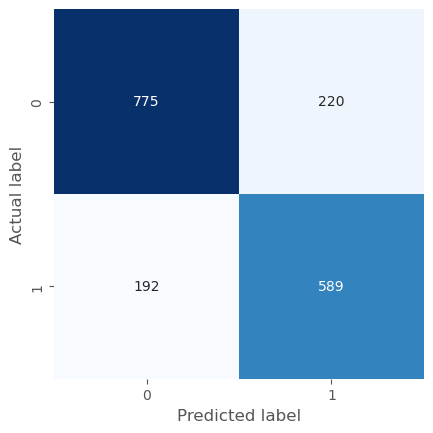

In [17]:
#dt_confusion_matrix = confusion_matrix(y_test,predictions)
dt_confusion_matrix = confusion_matrix(y_test,y_pred)
labels = [0, 1]

sns.heatmap(dt_confusion_matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

dt_classification_report = classification_report(y_test,y_pred)
dt_accuracy = accuracy_score(y_test,y_pred)
dt_precision = precision_score(y_test,y_pred)
dt_recall = recall_score(y_test,y_pred)
dt_f1 = f1_score(y_test,y_pred)

print("Classification Report: ")
print(dt_classification_report)

print("Confusion Matrix: ")
print(dt_confusion_matrix)

print("Accuracy: ", dt_accuracy)
print("Precision: ",dt_precision)
print("Recall: ",dt_recall)
print("F1: ",dt_f1)
print('Time taken: ', datetime.now()-start)

plt.show()


In [18]:
# Evaluate performance on the training set
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Evaluate performance on the test set
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the performance metrics
print("Training accuracy: {:.2f}".format(train_acc))
print("Training precision: {:.2f}".format(train_prec))
print("Training recall: {:.2f}".format(train_rec))
print("Training recall: {:.2f}".format(train_f1))
print("Test accuracy: {:.2f}".format(test_acc))
print("Test precision: {:.2f}".format(test_prec))
print("Test recall: {:.2f}".format(test_rec))
print("Test recall: {:.2f}".format(test_f1))

Training accuracy: 1.00
Training precision: 1.00
Training recall: 1.00
Training recall: 1.00
Test accuracy: 0.77
Test precision: 0.73
Test recall: 0.75
Test recall: 0.74


### Decision Tree with Hyperparamters tuning (GridSearchCV)

In [19]:
# Create a decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Define the parameter grid to search over
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV object
best_model_dt = grid_search.best_estimator_

# Get the best set of params
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

# Make predictions on the test data
y_pred = best_model_dt.predict(X_test)


 The best parameters across ALL searched params:
 {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}


Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       995
           1       0.69      0.84      0.76       781

    accuracy                           0.76      1776
   macro avg       0.77      0.77      0.76      1776
weighted avg       0.78      0.76      0.76      1776

Confusion Matrix: 
[[701 294]
 [127 654]]
Accuracy:  0.7629504504504504
Precision:  0.689873417721519
Recall:  0.8373879641485276
F1:  0.7565066512434934
Time taken:  0:02:05.764020


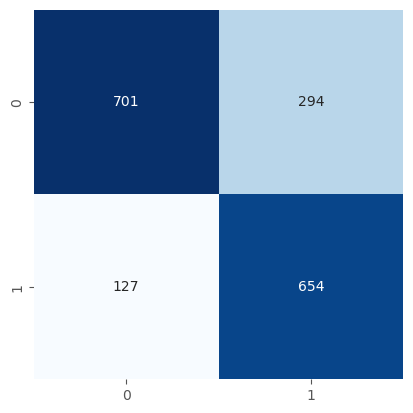

In [20]:
matrix = confusion_matrix(y_test,y_pred)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

report = classification_report(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ", f1)
print('Time taken: ', datetime.now()-start)

plt.show()


In [21]:
# Evaluate performance on the training set
y_train_pred = best_model_dt.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Evaluate performance on the test set
y_test_pred = best_model_dt.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the performance metrics
print("Training accuracy: {:.2f}".format(train_acc))
print("Training precision: {:.2f}".format(train_prec))
print("Training recall: {:.2f}".format(train_rec))
print("Training recall: {:.2f}".format(train_f1))
print("Test accuracy: {:.2f}".format(test_acc))
print("Test precision: {:.2f}".format(test_prec))
print("Test recall: {:.2f}".format(test_rec))
print("Test recall: {:.2f}".format(test_f1))

Training accuracy: 0.81
Training precision: 0.74
Training recall: 0.88
Training recall: 0.81
Test accuracy: 0.76
Test precision: 0.69
Test recall: 0.84
Test recall: 0.76


### Random Forest

A random forest is used here to produce a more accurate and stable prediction, and has improved the accuracy of the decision tree

In [22]:
clf = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=42)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
229,0,0
7765,0,0
3328,1,1
2572,1,1
5044,0,0
7436,0,0
8437,0,0
1691,1,1
6460,0,0
6785,0,0


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       995
           1       0.81      0.82      0.82       781

    accuracy                           0.84      1776
   macro avg       0.83      0.84      0.83      1776
weighted avg       0.84      0.84      0.84      1776

Confusion Matrix: 
[[849 146]
 [143 638]]
Accuracy:  0.8372747747747747
Precision:  0.8137755102040817
Recall:  0.8169014084507042
F1:  0.815335463258786
Time taken:  0:03:21.283346


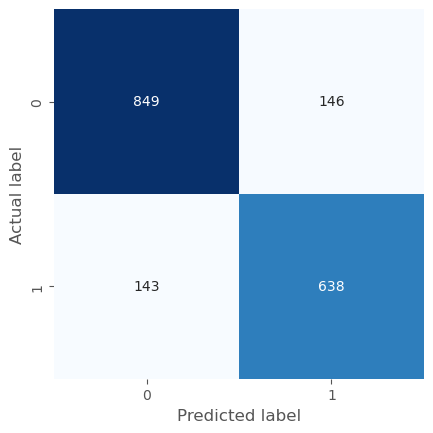

In [23]:
rf_confusion_matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(rf_confusion_matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

rf_classification_report = classification_report(y_test,predictions)
rf_accuracy = accuracy_score(y_test,predictions)
rf_precision = precision_score(y_test,predictions)
rf_recall = recall_score(y_test,predictions)
rf_f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(rf_classification_report)

print("Confusion Matrix: ")
print(rf_confusion_matrix)

print("Accuracy: ", rf_accuracy)
print("Precision: ",rf_precision)
print("Recall: ",rf_recall)
print("F1: ",rf_f1)
print('Time taken: ', datetime.now()-start)

plt.show()


In [24]:
# Evaluate performance on the training set
y_train_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Evaluate performance on the test set
y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print the performance metrics
print("Training accuracy: {:.2f}".format(train_acc))
print("Training precision: {:.2f}".format(train_prec))
print("Training recall: {:.2f}".format(train_rec))
print("Training recall: {:.2f}".format(train_f1))
print("Test accuracy: {:.2f}".format(test_acc))
print("Test precision: {:.2f}".format(test_prec))
print("Test recall: {:.2f}".format(test_rec))
print("Test recall: {:.2f}".format(test_f1))

Training accuracy: 1.00
Training precision: 1.00
Training recall: 1.00
Training recall: 1.00
Test accuracy: 0.84
Test precision: 0.81
Test recall: 0.82
Test recall: 0.82


### Random Forest with Hyperparameter Tuning (GridSearchCV)

In [25]:
# Create a random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [2, 4, 8]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV object
best_model_rf = grid_search.best_estimator_

# Get the best set of params
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

# Use the best model to make predictions on the test set
y_pred = best_model_rf.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df.sample(10)


 The best parameters across ALL searched params:
 {'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 50}


,Actual,Predicted
2698,1,1
4077,1,0
5173,0,0
1516,1,1
6200,0,0
7370,1,1
6934,0,0
3438,1,1
1726,1,1
8014,0,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       995
           1       0.77      0.81      0.79       781

    accuracy                           0.81      1776
   macro avg       0.81      0.81      0.81      1776
weighted avg       0.81      0.81      0.81      1776

Confusion Matrix: 
[[810 185]
 [152 629]]
Accuracy:  0.8102477477477478
Precision:  0.7727272727272727
Recall:  0.8053777208706786
F1:  0.7887147335423198
Time taken:  0:05:56.918157


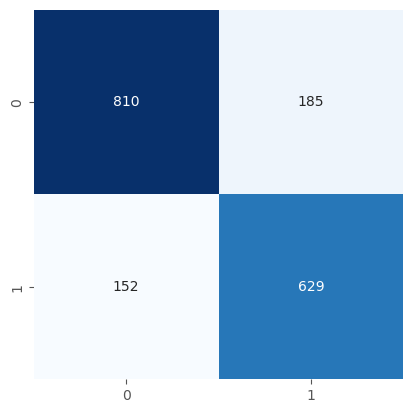

In [26]:
matrix = confusion_matrix(y_test,y_pred)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

report = classification_report(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ", f1)
print('Time taken: ', datetime.now()-start)

plt.show()


In [27]:
# Evaluate performance on the training set
y_train_pred = best_model_rf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)

# Evaluate performance on the test set
y_test_pred = best_model_rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)

# Print the performance metrics
print("Training accuracy: {:.2f}".format(train_acc))
print("Training precision: {:.2f}".format(train_prec))
print("Training recall: {:.2f}".format(train_rec))
print("Test accuracy: {:.2f}".format(test_acc))
print("Test precision: {:.2f}".format(test_prec))
print("Test recall: {:.2f}".format(test_rec))

Training accuracy: 0.85
Training precision: 0.81
Training recall: 0.86
Test accuracy: 0.81
Test precision: 0.77
Test recall: 0.81


### Naive Bayes

In [28]:
gnb =GaussianNB()

gnb.fit(X_train, y_train)
predictions = clf.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
8776,0,0
8435,1,1
2577,1,1
7811,0,0
7130,0,0
3055,1,1
5268,0,0
1010,0,0
5425,0,0
7955,1,0


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       995
           1       0.81      0.82      0.82       781

    accuracy                           0.84      1776
   macro avg       0.83      0.84      0.83      1776
weighted avg       0.84      0.84      0.84      1776

Confusion Matrix: 
[[849 146]
 [143 638]]
Accuracy:  0.8372747747747747
Precision:  0.8137755102040817
Recall:  0.8169014084507042
F1:  0.815335463258786
Time taken:  0:05:58.287978


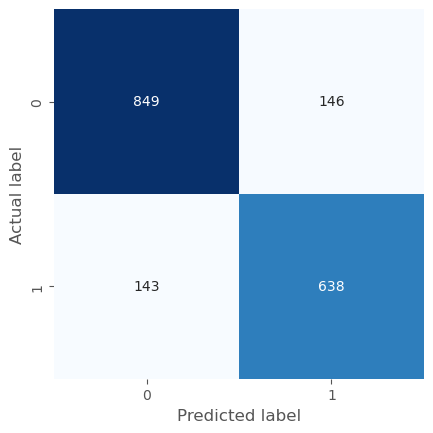

In [29]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### K-Nearest Neighbors (KNN)

In [30]:
# Attempt to find a good k value
error_rate = []

for i in range(1, 10):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train,y_train)
  pred_i = knn.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))


In [31]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Text(0, 0.5, 'Error Rate')

We select k = 5

In [32]:
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train,y_train)
predictions = knn.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
1166,1,0
7488,0,0
5813,0,0
6916,0,0
5351,0,0
1840,0,1
7962,1,1
3424,0,0
7429,0,0
393,1,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.78      0.81       995
           1       0.74      0.80      0.77       781

    accuracy                           0.79      1776
   macro avg       0.79      0.79      0.79      1776
weighted avg       0.79      0.79      0.79      1776

Confusion Matrix: 
[[777 218]
 [155 626]]
Accuracy:  0.7899774774774775
Precision:  0.7417061611374408
Recall:  0.8015364916773368
F1:  0.7704615384615385
Time taken:  0:06:02.792766


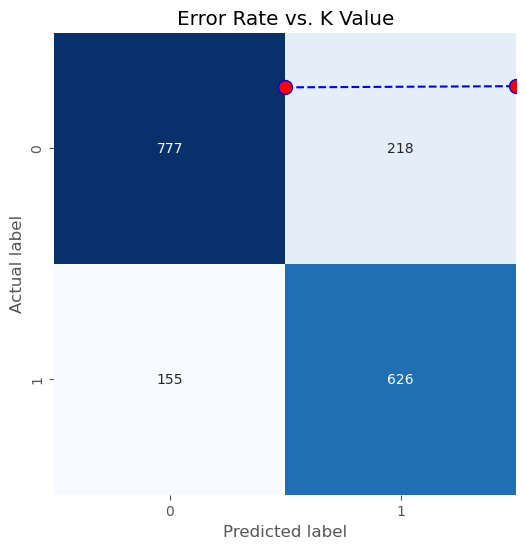

In [33]:
knn_confusion_matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(knn_confusion_matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

knn_classification_report = classification_report(y_test,predictions)
knn_accuracy = accuracy_score(y_test,predictions)
knn_precision = precision_score(y_test,predictions)
knn_recall = recall_score(y_test,predictions)
knn_f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(knn_classification_report)

print("Confusion Matrix: ")
print(knn_confusion_matrix)

print("Accuracy: ", knn_accuracy)
print("Precision: ",knn_precision)
print("Recall: ",knn_recall)
print("F1: ",knn_f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Support Vector Machine (SVM)

In [34]:
svm = LinearSVC(random_state=42)

# Fit the new SVM model to the training data
svm.fit(X_train, y_train)


#Use the trained model to predict the test data
predictions = svm.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
2883,1,1
3960,0,0
5780,0,1
7291,1,1
8310,0,1
7544,0,0
4800,0,0
2317,0,0
1183,1,0
511,1,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       995
           1       0.69      0.68      0.69       781

    accuracy                           0.73      1776
   macro avg       0.72      0.72      0.72      1776
weighted avg       0.73      0.73      0.73      1776

Confusion Matrix: 
[[760 235]
 [249 532]]
Accuracy:  0.7274774774774775
Precision:  0.6936114732724902
Recall:  0.6811779769526248
F1:  0.6873385012919897
Time taken:  0:06:04.108395


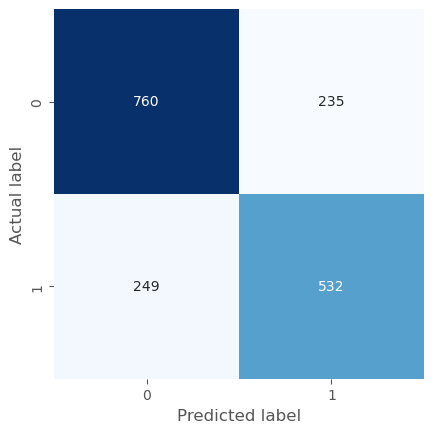

In [35]:
svm_confusion_matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(svm_confusion_matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

svm_classification_report = classification_report(y_test,predictions)
svm_accuracy = accuracy_score(y_test,predictions)
svm_precision = precision_score(y_test,predictions)
svm_recall = recall_score(y_test,predictions)
svm_f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(svm_classification_report)

print("Confusion Matrix: ")
print(svm_confusion_matrix)

print("Accuracy: ", svm_accuracy)
print("Precision: ",svm_precision)
print("Recall: ",svm_recall)
print("F1: ",svm_f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### eXtreme Gradient Boosting

In [36]:
xgbc = XGBClassifier(learning_rate=0.1, max_depth=9, random_state=42)

#Fit the training feature Xs and training label Ys
xgbc.fit(X_train, y_train)

#Use the trained model to predict the test data
predictions = xgbc.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
510,0,0
5769,0,0
7535,0,0
7740,1,1
8867,0,0
87,1,1
5906,0,1
1616,1,1
8285,0,1
6967,0,0


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       995
           1       0.80      0.83      0.82       781

    accuracy                           0.84      1776
   macro avg       0.83      0.83      0.83      1776
weighted avg       0.84      0.84      0.84      1776

Confusion Matrix: 
[[837 158]
 [134 647]]
Accuracy:  0.8355855855855856
Precision:  0.8037267080745342
Recall:  0.8284250960307298
F1:  0.815889029003783
Time taken:  0:06:08.346065


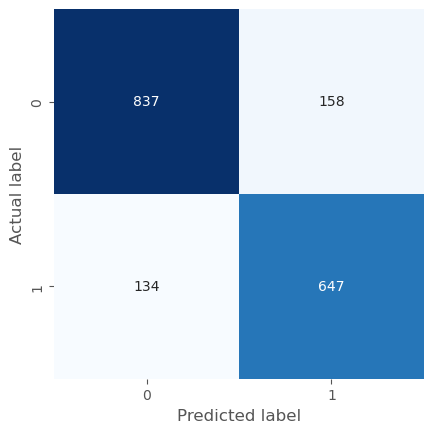

In [37]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Feedforward Neural Network

In [38]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))  # add dropout layer with a rate of 0.2
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))  # add dropout layer with a rate of 0.2
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                176       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
222/222 [==============================] - 5s 6ms/step - loss: 0.6757 - accuracy: 0.5874 - val_loss: 0.5737 - val_accuracy: 0.7303
Epoch 2/100
222/222 [==============================] - 1s 5ms/step - loss: 0.5583 - accuracy: 0.6911 - val_loss: 0.4934 - val_accuracy: 0.7551
Epoch 3/100
222/222 [==============================] - 1s 6ms/step - loss: 0.5214 - accuracy: 0.7163 - val_loss: 0.4643 - val_accuracy: 0.7714
Epoch 4/100
222/222 [==============================] - 1s 6ms/step - loss: 0.4949 - accuracy: 0.7385 - val_loss: 0.4429 - val_accuracy: 0.7804
Epoch 5/100
222/222 [==============================] - 1s 6ms/step - loss: 0.4870 - accuracy: 0.7405 - val_loss: 0.4283 - val_accuracy: 0.7922
Epoch 6/100
222/222 [==============================] - 1s 6ms/step - loss: 0.4700 - accuracy: 0.7522 - val_loss: 0.4163 - val_accuracy: 0.8052
Epoch 7/100
222/222 [==============================] - 1s 6ms/step - loss: 0.4608 - accuracy: 0.7625 - val_loss: 0.4036 - val_accuracy: 0.8080

Epoch 58/100
222/222 [==============================] - 1s 4ms/step - loss: 0.3072 - accuracy: 0.8586 - val_loss: 0.2592 - val_accuracy: 0.8857
Epoch 59/100
222/222 [==============================] - 1s 4ms/step - loss: 0.3082 - accuracy: 0.8529 - val_loss: 0.2613 - val_accuracy: 0.8789
Epoch 60/100
222/222 [==============================] - 1s 5ms/step - loss: 0.3033 - accuracy: 0.8545 - val_loss: 0.2541 - val_accuracy: 0.8823
Epoch 61/100
222/222 [==============================] - 1s 5ms/step - loss: 0.2995 - accuracy: 0.8582 - val_loss: 0.2520 - val_accuracy: 0.8970
Epoch 62/100
222/222 [==============================] - 1s 6ms/step - loss: 0.3037 - accuracy: 0.8607 - val_loss: 0.2566 - val_accuracy: 0.8908
Epoch 63/100
222/222 [==============================] - 1s 6ms/step - loss: 0.2936 - accuracy: 0.8616 - val_loss: 0.2496 - val_accuracy: 0.8863
Epoch 64/100
222/222 [==============================] - 2s 8ms/step - loss: 0.2900 - accuracy: 0.8593 - val_loss: 0.2394 - val_accuracy:

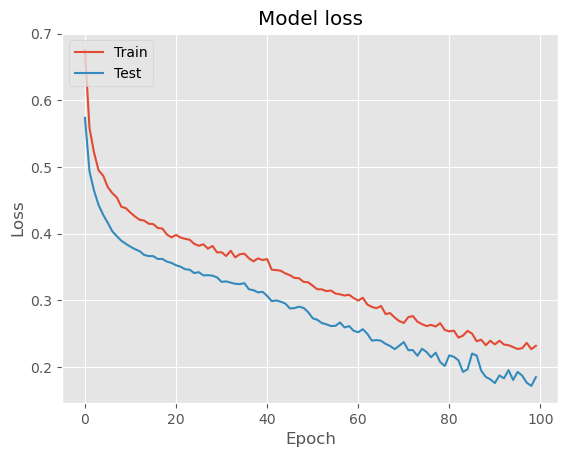

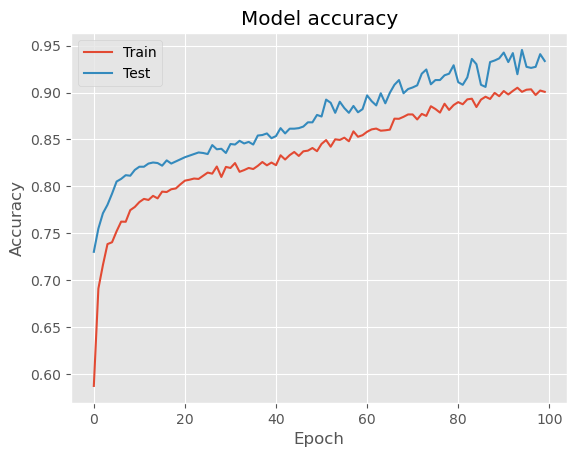

In [39]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=100, batch_size=32)

#Plot the loss curve
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

#Plot the accurcy curve
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

56/56 [==============================] - 0s 3ms/step
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       995
           1       0.94      0.91      0.92       781

    accuracy                           0.93      1776
   macro avg       0.93      0.93      0.93      1776
weighted avg       0.93      0.93      0.93      1776

Confusion Matrix: 
[[950  45]
 [ 73 708]]
Accuracy:  0.9335585585585585
Precision:  0.9402390438247012
Recall:  0.9065300896286812
F1:  0.9230769230769231
Time taken:  0:08:17.059359


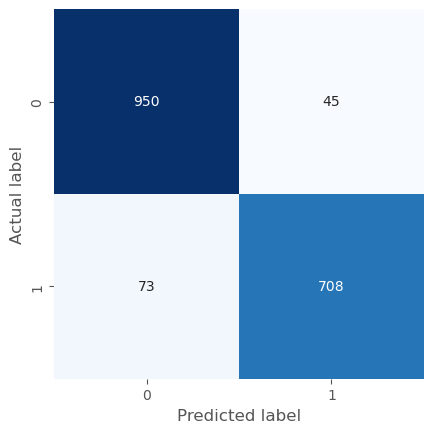

In [40]:
y_predicted = model.predict(X_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = [0, 1]

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

matrix = confusion_matrix(y_test,y_predicted)
report = classification_report(y_test,y_predicted)
accuracy = accuracy_score(y_test,y_predicted)
precision = precision_score(y_test,y_predicted)
recall = recall_score(y_test,y_predicted)
f1 = f1_score(y_test,y_predicted)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ", f1)
print('Time taken: ', datetime.now()-start)

plt.show()


## Unsupervised Learning

### K-Means Clustering

In [41]:
# find the optimal n_cluster number
SSE = []
for i in range(1,15):
    model = KMeans(n_clusters = i, n_init='auto', random_state=42)
    model.fit(X_train)
    SSE.append(model.inertia_)

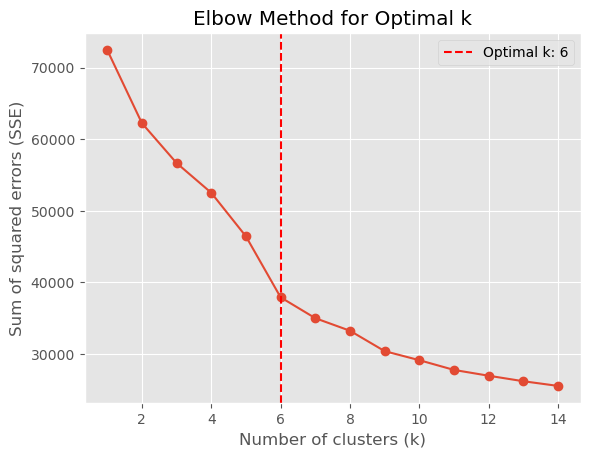

In [42]:
# Plot SSE vs. k
plt.plot(range(1, 15), SSE, marker='o')

# Plot vertical line for optimal k
optimal_k = 6
plt.axvline(x=optimal_k, linestyle='--', color='red', label=f'Optimal k: {optimal_k}')

# Add labels and title to the plot
plt.legend()
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Show the plot
plt.show()

With the Elbow Method, we select n_cluster = 6 to perform our cluster analysis

In [43]:
# Create a KMeans object with the desired number of clusters
kmeans = KMeans(n_clusters=6, random_state=42)

# Fit the KMeans model to the data
kmeans.fit(X_train)

KMeans(n_clusters=6, random_state=42)

In [44]:
print("SSE :", round(kmeans.inertia_, 1))
print("Num of iterations :" , kmeans.n_iter_)
print("\nCluster centers :" , kmeans.cluster_centers_)

SSE : 37918.4
Num of iterations : 27

Cluster centers : [[ 1.09529251e+00  1.33877554e-01 -4.57171511e-01 -1.67584334e+00
   1.85787348e-01  5.08626312e-01  6.99402347e-01  7.06289317e-01
   1.92982173e-02  9.59683005e-03]
 [ 8.19028781e-01 -3.36809335e-01 -1.53456701e-03  2.16348329e-01
  -3.56740551e-01 -2.60351452e-01 -3.93589898e-01 -3.39314140e-01
   1.46365219e-02  8.09675359e-02]
 [-8.70627054e-01 -8.79910486e-01  1.59127754e+00 -5.56957589e-02
   8.59693600e-01  1.22314742e-01  3.86698831e-01 -4.01003978e-01
   8.76051172e-03  3.12155668e-02]
 [-1.32904560e+00  4.28040875e-01 -4.57306376e-01  1.37978264e-01
  -1.82202158e-01 -7.39813313e-02 -1.50993944e-01  5.17232474e-02
   1.48385850e-02 -1.17490088e-01]
 [ 2.43168730e+00  9.14385620e+00  3.71300353e+00  9.84915574e-01
   4.45534429e-01 -4.26462438e-01 -1.09087137e-01  2.98502755e-01
  -1.42681541e+00  2.11359650e-01]
 [ 1.89552693e+00 -7.90654857e-01 -1.17957161e+00  4.12922520e+00
   1.63237773e+00  1.34802159e+00  1.365504

In [45]:
# Predict the cluster labels for the test data
y_pred = kmeans.predict(X_test)

In [46]:
# Evaluate the performance of the model
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(X_test, y_pred)
print("Silhouette score:", silhouette)

Silhouette score: 0.21866766380369151


### Ensemble Learning [Boosting]

### Logistic Regression

In [47]:
#Create the AdaBoost classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
# - learning_rate controls the weight adjustments of each base classifiers. Default is 1
model = AdaBoostClassifier(base_estimator=LogisticRegression(),n_estimators=50,learning_rate=0.1, random_state=42)

#Fit the training feature Xs and training label Ys
model.fit(X_train, y_train)

#Use the trained model to predict the test data
predictions = model.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)


,Actual,Predicted
2897,1,0
6595,0,0
7010,1,0
4375,0,0
7618,1,0
1261,0,1
7794,0,0
5306,0,0
6437,0,0
8794,0,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       995
           1       0.72      0.62      0.67       781

    accuracy                           0.73      1776
   macro avg       0.73      0.72      0.72      1776
weighted avg       0.73      0.73      0.72      1776

Confusion Matrix: 
[[804 191]
 [293 488]]
Accuracy:  0.7274774774774775
Precision:  0.7187039764359352
Recall:  0.6248399487836107
F1:  0.6684931506849315
Time taken:  0:08:22.273908


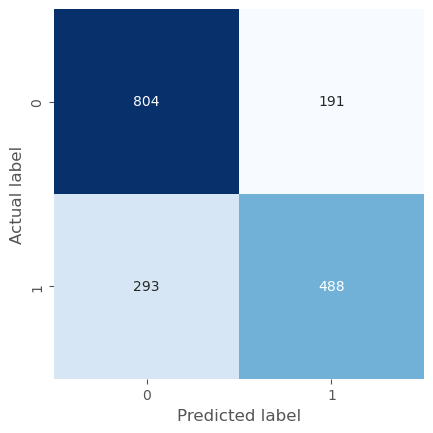

In [48]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Decision Tree

In [49]:
#Create the AdaBoost classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
# - learning_rate controls the weight adjustments of each base classifiers. Default is 1
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', random_state=42), n_estimators=50,learning_rate=0.1)

#Fit the training feature Xs and training label Ys
model.fit(X_train, y_train)

#Use the trained model to predict the test data
predictions = model.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
2273,1,1
8182,0,1
3944,1,1
7284,0,0
5128,0,1
8794,0,1
6676,0,1
7198,1,0
5267,0,0
2249,1,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       995
           1       0.72      0.75      0.73       781

    accuracy                           0.76      1776
   macro avg       0.76      0.76      0.76      1776
weighted avg       0.76      0.76      0.76      1776

Confusion Matrix: 
[[771 224]
 [199 582]]
Accuracy:  0.7618243243243243
Precision:  0.7220843672456576
Recall:  0.7451984635083226
F1:  0.7334593572778829
Time taken:  0:08:23.039646


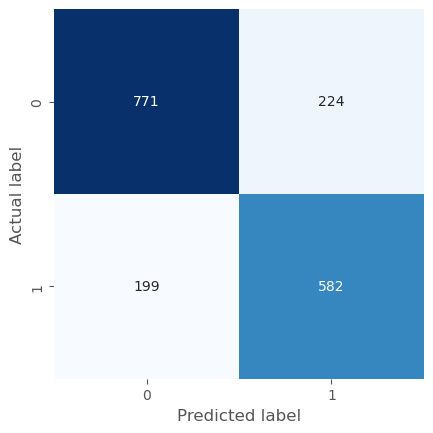

In [50]:
dt_confusion_matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(dt_confusion_matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

dt_classification_report = classification_report(y_test,predictions)
dt_accuracy = accuracy_score(y_test,predictions)
dt_precision = precision_score(y_test,predictions)
dt_recall = recall_score(y_test,predictions)
dt_f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(dt_classification_report)

print("Confusion Matrix: ")
print(dt_confusion_matrix)

print("Accuracy: ", dt_accuracy)
print("Precision: ",dt_precision)
print("Recall: ",dt_recall)
print("F1: ",dt_f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Decision Tree (with GridSearchCV)

In [51]:
# Create a decision tree classifier as the base estimator
base_estimator = best_model_dt

# Create the AdaBoostClassifier object
ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

ada.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ada.predict(X_test)

Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       995
           1       0.78      0.78      0.78       781

    accuracy                           0.81      1776
   macro avg       0.81      0.80      0.80      1776
weighted avg       0.81      0.81      0.81      1776

Confusion Matrix: 
[[829 166]
 [175 606]]
Accuracy:  0.8079954954954955
Precision:  0.7849740932642487
Recall:  0.7759282970550576
F1:  0.780424983902125
Time taken:  0:08:42.816392


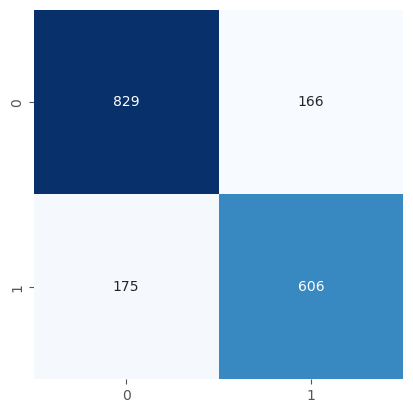

In [52]:
matrix = confusion_matrix(y_test,y_pred)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

report = classification_report(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ", f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Random Forest

In [53]:
abc = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=500, criterion='entropy'), n_estimators=50, learning_rate=0.1,algorithm = "SAMME", random_state=42)

abc.fit(X_train, y_train)

predictions = abc.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
1103,1,1
5780,0,0
3132,0,0
3977,1,1
3161,1,1
1656,0,1
3543,0,0
7942,1,1
251,0,1
1631,1,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       995
           1       0.81      0.81      0.81       781

    accuracy                           0.83      1776
   macro avg       0.83      0.83      0.83      1776
weighted avg       0.83      0.83      0.83      1776

Confusion Matrix: 
[[845 150]
 [148 633]]
Accuracy:  0.8322072072072072
Precision:  0.8084291187739464
Recall:  0.8104993597951344
F1:  0.8094629156010231
Time taken:  0:09:54.787592


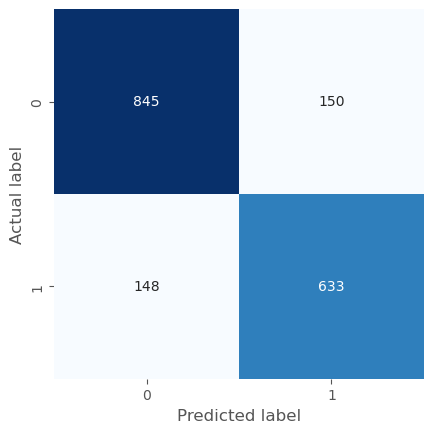

In [54]:
rf_confusion_matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(rf_confusion_matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

rf_classification_report = classification_report(y_test,predictions)
rf_accuracy = accuracy_score(y_test,predictions)
rf_precision = precision_score(y_test,predictions)
rf_recall = recall_score(y_test,predictions)
rf_f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(rf_classification_report)

print("Confusion Matrix: ")
print(rf_confusion_matrix)

print("Accuracy: ", rf_accuracy)
print("Precision: ",rf_precision)
print("Recall: ",rf_recall)
print("F1: ",rf_f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Random Forest (GridSearchCV)

In [55]:
# Create a decision tree classifier as the base estimator
base_estimator = best_model_rf

# Create the AdaBoostClassifier object
ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

ada.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ada.predict(X_test)

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       995
           1       0.81      0.83      0.82       781

    accuracy                           0.84      1776
   macro avg       0.84      0.84      0.84      1776
weighted avg       0.84      0.84      0.84      1776

Confusion Matrix: 
[[845 150]
 [133 648]]
Accuracy:  0.8406531531531531
Precision:  0.8120300751879699
Recall:  0.8297055057618438
F1:  0.8207726409119696
Time taken:  0:12:58.576515


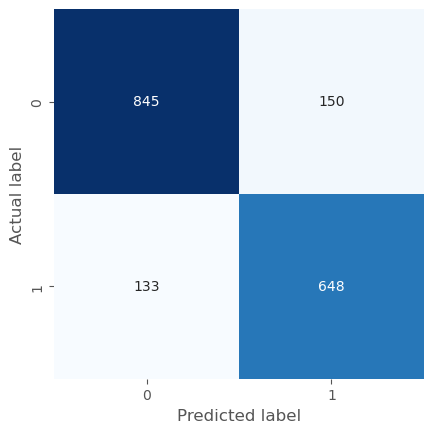

In [56]:
rf_confusion_matrix = confusion_matrix(y_test,y_pred)

labels = [0, 1]

sns.heatmap(rf_confusion_matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

rf_classification_report = classification_report(y_test,y_pred)
rf_accuracy = accuracy_score(y_test,y_pred)
rf_precision = precision_score(y_test,y_pred)
rf_recall = recall_score(y_test,y_pred)
rf_f1 = f1_score(y_test,y_pred)

print("Classification Report: ")
print(rf_classification_report)

print("Confusion Matrix: ")
print(rf_confusion_matrix)

print("Accuracy: ", rf_accuracy)
print("Precision: ",rf_precision)
print("Recall: ",rf_recall)
print("F1: ",rf_f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Naive Bayes

In [57]:
#Initialize or define the model
model = AdaBoostClassifier(n_estimators=50, base_estimator=GaussianNB(), learning_rate=0.1, random_state=42)

#Fit the training feature Xs and training label Ys
model.fit(X_train, y_train)

#Use the trained model to predict the test data
predictions = model.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
1056,1,1
3615,1,1
4071,0,0
3106,1,1
4420,0,0
5632,0,0
132,0,0
5884,0,1
7638,0,0
1623,1,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       995
           1       0.72      0.75      0.74       781

    accuracy                           0.76      1776
   macro avg       0.76      0.76      0.76      1776
weighted avg       0.76      0.76      0.76      1776

Confusion Matrix: 
[[771 224]
 [196 585]]
Accuracy:  0.7635135135135135
Precision:  0.723114956736712
Recall:  0.7490396927016645
F1:  0.7358490566037735
Time taken:  0:12:59.779290


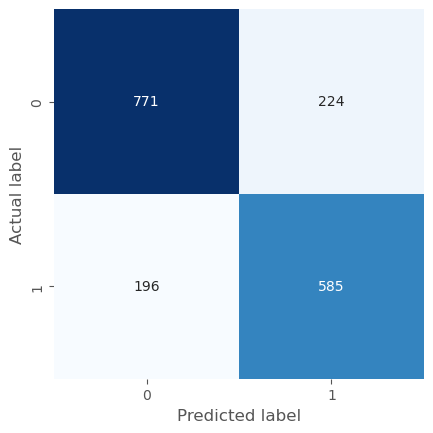

In [58]:
nb_confusion_matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(nb_confusion_matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

nb_classification_report = classification_report(y_test,predictions)
nb_accuracy = accuracy_score(y_test,predictions)
nb_precision = precision_score(y_test,predictions)
nb_recall = recall_score(y_test,predictions)
nb_f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(nb_classification_report)

print("Confusion Matrix: ")
print(nb_confusion_matrix)

print("Accuracy: ", nb_accuracy)
print("Precision: ",nb_precision)
print("Recall: ",nb_recall)
print("F1: ",nb_f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Support Vector Machine (SVM)

In [59]:
svm = LinearSVC(random_state=42)
model = AdaBoostClassifier(n_estimators=50, learning_rate = 0.1, base_estimator=svm,algorithm='SAMME', random_state=42)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
764,0,0
2127,1,1
576,1,0
1175,1,0
4241,0,0
7515,0,1
6894,1,1
8665,0,0
7488,0,0
4554,0,0


Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       995
           1       0.70      0.67      0.68       781

    accuracy                           0.73      1776
   macro avg       0.72      0.72      0.72      1776
weighted avg       0.73      0.73      0.73      1776

Confusion Matrix: 
[[772 223]
 [260 521]]
Accuracy:  0.7280405405405406
Precision:  0.7002688172043011
Recall:  0.6670934699103713
F1:  0.6832786885245902
Time taken:  0:13:01.336320


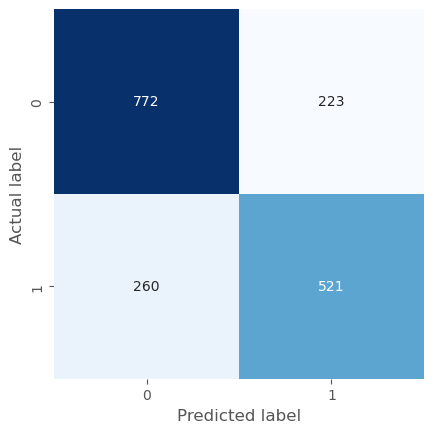

In [60]:
svm_confusion_matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(svm_confusion_matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

svm_classification_report = classification_report(y_test,predictions)
svm_accuracy = accuracy_score(y_test,predictions)
svm_precision = precision_score(y_test,predictions)
svm_recall = recall_score(y_test,predictions)
svm_f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(svm_classification_report)

print("Confusion Matrix: ")
print(svm_confusion_matrix)

print("Accuracy: ", svm_accuracy)
print("Precision: ",svm_precision)
print("Recall: ",svm_recall)
print("F1: ",svm_f1)
print('Time taken: ', datetime.now()-start)

plt.show()


## Ensemble Learning [Bagging]

### Logistic Regression

In [61]:
bag_model = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=50, bootstrap=True,oob_score=True,random_state=42)

bag_model.fit(X_train, y_train)

predictions = bag_model.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
6664,0,0
8301,0,0
4568,1,1
2970,1,1
1626,1,1
2523,0,0
2680,1,1
2522,1,1
8749,1,1
3555,0,0


Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       995
           1       0.71      0.68      0.70       781

    accuracy                           0.74      1776
   macro avg       0.73      0.73      0.73      1776
weighted avg       0.74      0.74      0.74      1776

Confusion Matrix: 
[[780 215]
 [250 531]]
Accuracy:  0.7381756756756757
Precision:  0.7117962466487936
Recall:  0.6798975672215108
F1:  0.6954813359528487
Time taken:  0:13:03.986339


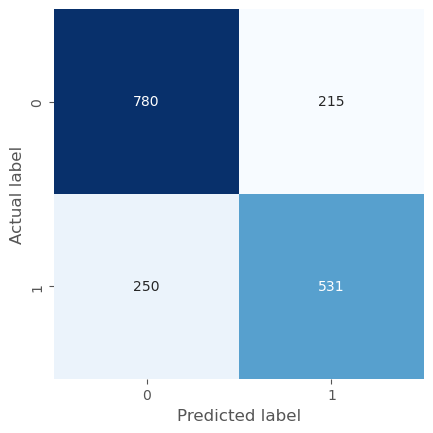

In [62]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Decision Tree

In [63]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', random_state=42), 
                          n_estimators=50, max_samples=0.8, max_features=0.8, random_state=42)

# Fit the training feature Xs and training label Ys
model.fit(X_train, y_train)

# Use the trained model to predict the test data
predictions = model.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
8044,0,0
5358,0,1
1467,1,1
1575,1,1
7912,1,1
8295,0,0
6324,1,1
3123,1,1
733,1,1
6857,0,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       995
           1       0.81      0.82      0.82       781

    accuracy                           0.84      1776
   macro avg       0.84      0.84      0.84      1776
weighted avg       0.84      0.84      0.84      1776

Confusion Matrix: 
[[849 146]
 [140 641]]
Accuracy:  0.838963963963964
Precision:  0.8144853875476493
Recall:  0.8207426376440461
F1:  0.8176020408163265
Time taken:  0:13:17.990483


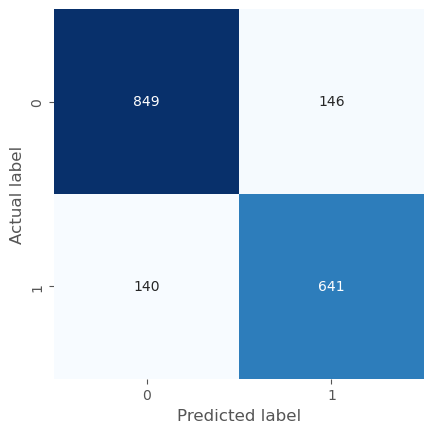

In [64]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Decision Tree (GridSearchCV)

In [65]:
# Create a decision tree classifier as the base estimator
base_estimator = best_model_dt

# Create the AdaBoostClassifier object
dt_bag = BaggingClassifier(base_estimator=base_estimator, random_state=42)

dt_bag.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_bag.predict(X_test)

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       995
           1       0.75      0.81      0.78       781

    accuracy                           0.80      1776
   macro avg       0.79      0.80      0.79      1776
weighted avg       0.80      0.80      0.80      1776

Confusion Matrix: 
[[780 215]
 [147 634]]
Accuracy:  0.7961711711711712
Precision:  0.7467608951707891
Recall:  0.8117797695262484
F1:  0.7779141104294478
Time taken:  0:13:20.439285


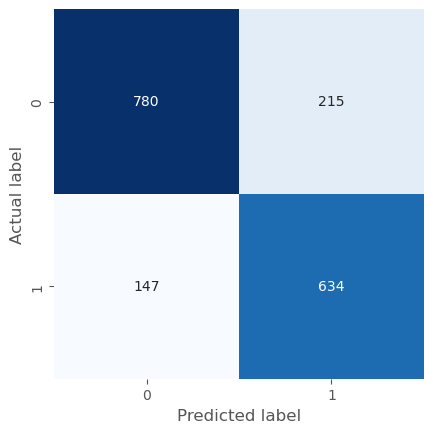

In [66]:
matrix = confusion_matrix(y_test,y_pred)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Random Forest

In [67]:
bag_model = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=500, criterion='entropy'), n_estimators=50, bootstrap=True,oob_score=True,random_state=42)

bag_model.fit(X_train, y_train)

predictions = bag_model.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)


,Actual,Predicted
6415,1,1
2755,1,1
1586,1,1
8707,0,0
7855,0,0
3480,1,1
511,1,1
6987,1,1
5229,0,0
6179,0,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       995
           1       0.81      0.83      0.82       781

    accuracy                           0.84      1776
   macro avg       0.84      0.84      0.84      1776
weighted avg       0.84      0.84      0.84      1776

Confusion Matrix: 
[[847 148]
 [134 647]]
Accuracy:  0.8412162162162162
Precision:  0.8138364779874214
Recall:  0.8284250960307298
F1:  0.8210659898477157
Time taken:  0:42:51.139795


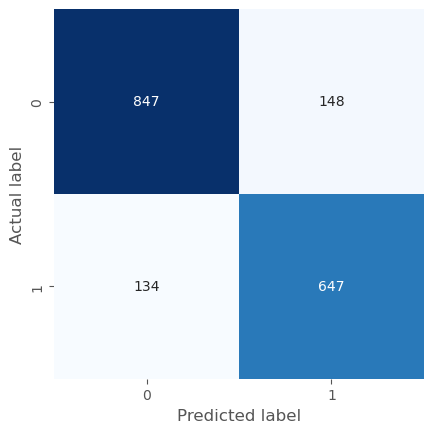

In [68]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Random Forest (GridSearchCV)

In [69]:
base_estimator = best_model_rf

# Create the AdaBoostClassifier object
rf_bag = BaggingClassifier(base_estimator=base_estimator, random_state=42)

rf_bag.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_bag.predict(X_test)

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       995
           1       0.78      0.80      0.79       781

    accuracy                           0.81      1776
   macro avg       0.81      0.81      0.81      1776
weighted avg       0.81      0.81      0.81      1776

Confusion Matrix: 
[[818 177]
 [160 621]]
Accuracy:  0.8102477477477478
Precision:  0.7781954887218046
Recall:  0.795134443021767
F1:  0.7865737808739709
Time taken:  0:43:19.104049


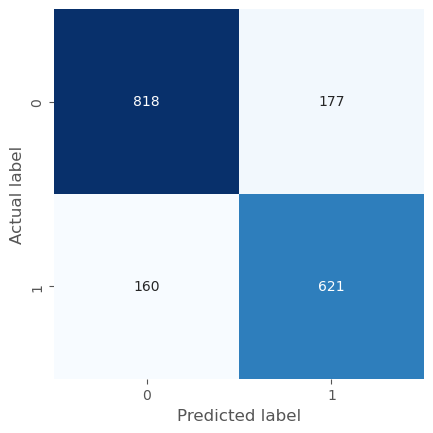

In [70]:
matrix = confusion_matrix(y_test,y_pred)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Naive Bayes

In [71]:
bag_model = BaggingClassifier(base_estimator=GaussianNB(), n_estimators=50, bootstrap=True,oob_score=True,random_state=42)

bag_model.fit(X_train, y_train)

predictions = bag_model.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)


,Actual,Predicted
1844,0,0
3018,0,0
3106,1,1
1287,1,0
7441,0,0
2576,1,1
472,1,0
4381,0,0
7291,1,0
41,0,0


Classification Report: 
              precision    recall  f1-score   support

           0       0.66      0.93      0.77       995
           1       0.81      0.39      0.53       781

    accuracy                           0.69      1776
   macro avg       0.74      0.66      0.65      1776
weighted avg       0.73      0.69      0.66      1776

Confusion Matrix: 
[[925  70]
 [478 303]]
Accuracy:  0.6914414414414415
Precision:  0.8123324396782842
Recall:  0.3879641485275288
F1:  0.5251299826689775
Time taken:  0:43:31.592213


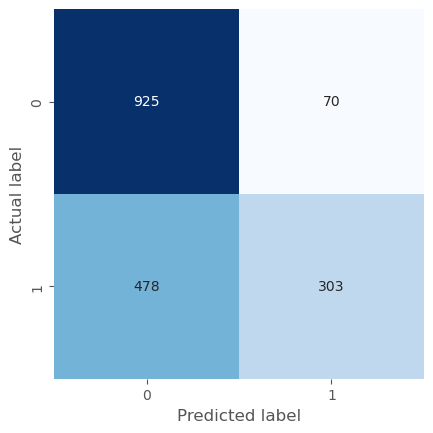

In [72]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### KNN

In [73]:
bag_model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=6), n_estimators=50, bootstrap=True,oob_score=True,random_state=42)

bag_model.fit(X_train, y_train)

predictions = bag_model.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
4506,0,0
3256,1,0
4983,0,0
4975,0,1
149,1,1
445,0,0
4141,1,1
5749,0,0
8285,0,1
476,0,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       995
           1       0.76      0.82      0.79       781

    accuracy                           0.81      1776
   macro avg       0.80      0.81      0.80      1776
weighted avg       0.81      0.81      0.81      1776

Confusion Matrix: 
[[793 202]
 [144 637]]
Accuracy:  0.8051801801801802
Precision:  0.7592371871275327
Recall:  0.8156209987195903
F1:  0.7864197530864198
Time taken:  0:43:40.995996


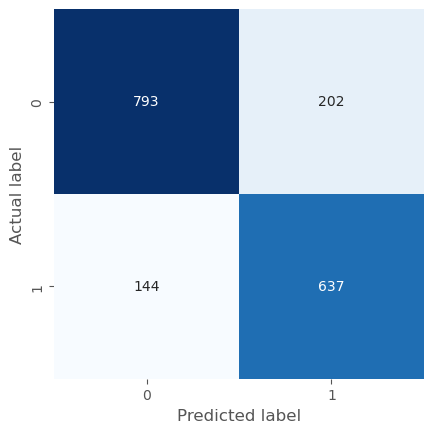

In [74]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()


### Support Vector Machine

In [75]:
svm = LinearSVC(random_state=42)
bag_model = BaggingClassifier(base_estimator=svm, n_estimators=50, bootstrap=True,oob_score=True,random_state=42)

bag_model.fit(X_train, y_train)


predictions = bag_model.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.sample(10)

,Actual,Predicted
5317,1,0
7856,0,1
5412,1,0
2142,0,0
2897,1,0
8871,0,0
518,1,1
393,1,0
7050,0,0
1027,1,1


Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       995
           1       0.70      0.68      0.69       781

    accuracy                           0.73      1776
   macro avg       0.72      0.72      0.72      1776
weighted avg       0.73      0.73      0.73      1776

Confusion Matrix: 
[[764 231]
 [252 529]]
Accuracy:  0.7280405405405406
Precision:  0.6960526315789474
Recall:  0.677336747759283
F1:  0.6865671641791045
Time taken:  0:43:55.233157


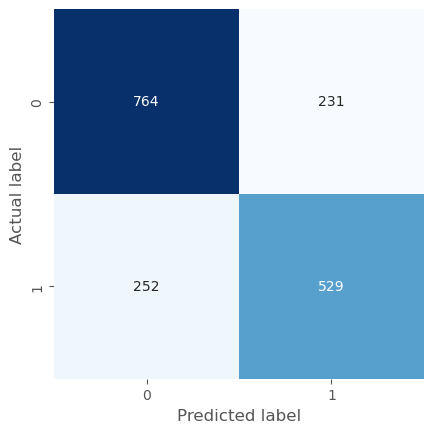

In [76]:
matrix = confusion_matrix(y_test,predictions)

labels = [0, 1]

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

report = classification_report(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)

print("Classification Report: ")
print(report)

print("Confusion Matrix: ")
print(matrix)

print("Accuracy: ", accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print('Time taken: ', datetime.now()-start)

plt.show()
